<a href="https://colab.research.google.com/github/bloup1/Ethics-III/blob/main/Summative_assessment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning
## Summative assessment
### Coursework 3

#### Instructions

This coursework is released on **Wednesday 20th March 9.00** and is due by **Wednesday 24th April 23.59**. It is worth **50%** of your overall mark. There are 4 questions in this assessment, and a total of 100 marks are available. **You should attempt to answer all questions.** In addition to the total number of marks per question below, an additional 5 marks is available for presentation and clarity/quality of code.

This assessment assesses your ability to design, implement, train and evaluate a generative deep learning model for a spoken audio dataset.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting.

#### Submission instructions

The submission for this assessment will consist of a notebook (.ipynb file), PDF report and model submission.

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also submit a PDF/HTML copy of your executed notebook, in case the .ipynb file is corrupted for some reason.

Upload a zip file containing your notebook, separate PDF/HTML file(s), model(s) and any other relevant files to Coursera by the deadline above.

This assignment must be attempted individually; your submission must be your own, unaided work. Candidates are prohibited from discussing assessed coursework, and must abide by [Imperial College’s rules](https://www.imperial.ac.uk/media/imperial-college/administration-and-support-services/registry/academic-governance/public/academic-policy/academic-integrity/Examination-and-assessments---academic-integrity.pdf) regarding academic integrity and plagiarism. Unless specifically authorised within the assignment instructions, the submission of output from [generative AI tools](https://www.imperial.ac.uk/about/leadership-and-strategy/provost/vice-provost-education/generative-ai-tools-guidance/) (e.g., ChatGPT) for assessed coursework is prohibited. Violations will be treated as an examination offence. Enabling other candidates to plagiarise your work constitutes an examination offence. To ensure quality assurance is maintained, departments may choose to invite a random selection of students to an ‘authenticity interview’ on their submitted assessments.

In [3]:
! pip install pydub==0.25.1 -q

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import os
from IPython.display import Audio, display

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer

In [5]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Files.zip", 'r')
zip_ref.extractall("/cswk3")
zip_ref.close()

Mounted at /content/drive/


In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### The Free Spoken Digit Dataset (FSDD)

This assessment makes use of the [Free Spoken Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset). This dataset consists of recordings of spoken digits by a number of different speakers, all recorded at a sample rate of 8kHz. The recordings are trimmed so that they have near minimal silence at the beginnings and ends.

For this assessment, we will use the version of the dataset made available through TensorFlow Datasets ([https://www.tensorflow.org/datasets/catalog/spoken_digit](https://www.tensorflow.org/datasets/catalog/spoken_digit)).

The dataset consists 2,500 recordings from 5 different speakers. Using the TensorFlow Datasets API, this dataset can be downloaded and stored directly in a Dataset object using the code below.

In [7]:
ds_train, ds_val, ds_test = tfds.load(
    'spoken_digit',
    split=['train[:60%]','train[60%:80%]','train[80%:]'],
    data_dir=os.path.join( "data", "spoken_digit"),
    shuffle_files=True
)

ds_whole = tfds.load(
    'spoken_digit',
    split='train',
    data_dir=os.path.join("data", "spoken_digit"),
    shuffle_files=True
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2500 [00:00<?, ? examples/s]

Shuffling data/spoken_digit/spoken_digit/1.0.9.incomplete3ACBQE/spoken_digit-train.tfrecord*...:   0%|        …

Dataset spoken_digit downloaded and prepared to data/spoken_digit/spoken_digit/1.0.9. Subsequent calls will reuse this data.


In [8]:
ds_train.element_spec

{'audio': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'audio/filename': TensorSpec(shape=(), dtype=tf.string, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}

#### VQ-VAE

The VQ-VAE was first developed in the following paper:

* van den Oord, A., Vinyals, O. & Kavukcuoglu, K. (2017), "Neural discrete representation learning", _Proceedings of the 31st International Conference on Neural Information Processing Systems_, 6309-6318.

In this assessment you will develop and train a vector-quantised variational autoencoder (VQ-VAE) model. This is a variant of the VAE algorithm that makes use of a discrete latent space. In particular, the VQ-VAE defines a _codebook_ $\mathbf{e} \in \mathbb{R}^{K \times D}$ for the latent embedding space, consisting of $K$ latent embedding vectors $e_i$ ($i=1,\ldots,K$), each of dimension $D$. The algorithm involves training encoder and decoder networks as usual. However, for a given input $x$, the encoder output $E(x) \in \mathbb{R}^D$ is quantised to the nearest latent embedding vector:

$$VQ(E(x)) = e_k,\quad\textrm{where }k = \underset{j}{\arg\min}||E(x) - e_j||_2,$$

where the $||\cdot||_2$ norm above is the Euclidean norm in $\mathbb{R}^D$. This quantized latent vector is then passed through the decoder to output the likelihood $p_\theta(x \mid z)$ as usual.

The quantisation stage of the VQ-VAE means that it is not possible to compute gradients with respect to the encoder variables. The solution to this problem in the VQ-VAE is to use the _straight through estimator_, in which the gradients computed with respect to the quantised embeddings are simply passed unaltered to the encoder. This process means that the codebook embeddings $e_i$ do not receive any gradient updates (for details, refer to the implementation referenced in question 3, which makes this process explicit). The VQ-VAE objective therefore adds two additional terms to learn the codebook embeddings:

$$
L = \mathbb{E}_{q_\phi(z \mid x)}[\log p_\theta(x \mid z) ] + ||\textrm{sg}[E(x)] - VQ(E(x))||^2_2 + \beta || E(x) - \textrm{sg}[VQ(E(x))]||_2^2
$$

In the above, $\textrm{sg}$ is the _stop gradient_ operator that is defined as identity in the forward pass but has zero partial derivates (see [`tf.stop_gradient`](https://www.tensorflow.org/api_docs/python/tf/stop_gradient)). This means that when evaluating the loss function above, the stop gradient operator can be ignored, but when computing derivatives of the loss with respect to the model parameters, the partial derivatives of $\textrm{sg}[E(x)]$ and $\textrm{sg}[VQ(E(x))]$ with respect to the model parameters will be zero. The constant $\beta$ is usually taken set to $\beta=0.25$ by default, as in the original paper.

The first term in the objective $L$ above is the reconstruction loss, the second term is the _codebook loss_, and the third term is the _commitment loss_. The Kullback-Leibler divergence term in the ELBO is constant and so is ignored for training.

In this assessment, you will design, implement, train and evaluate a VQ-VAE for the spoken digit dataset, and use it to learn a generative model of the spoken audio.

### Question 1 (Total 15 marks)

The loaded Dataset returns a dictionary with keys `"audio"`, `"audio/filename"` and `"label"`. For this assessment you will only need the `"audio"` entry, and the other entries can be discarded.

In this question, you should carry out a basic exploration and analysis of the dataset; computing, displaying and visualising any properties you deem to be relevant. You can also use comments and/or markdown as appropriate.

All of the Dataset preparation/preprocessing for question 2a) should be done in this question, so that it is ready for training the VQ-VAE.

_Hint: an audio file can be played within a jupyter notebook using the `Audio` class from the `IPython.display` module (imported above). See [here](https://ipython.org/ipython-doc/3/api/generated/IPython.display.html) for usage._

**(15 marks)**

In [9]:
! pip install librosa
! pip install tensorflow_io
import librosa


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 11.6 MB/s eta 0:00:00


In [11]:
# https://www.kaggle.com/datasets/joserzapata/free-spoken-digit-dataset-fsdd/code
# https://www.kaggle.com/code/holzner/variational-autoencoder-for-speech-dataset
# https://www.youtube.com/watch?v=UGTAzMX3vjQ

# visualize the data and padding:
# https://keras.io/examples/audio/ctc_asr/



In [12]:
##https://www.kaggle.com/code/iinaam/classification-on-fsdd-using-spectograms

import tensorflow_io as tfio
nfft = 1024
window = 1024
stride = 128


for elem in ds_train.take(5):
    my_elem = elem['audio']
    spectrogram = tfio.audio.spectrogram(tf.cast(my_elem,tf.float32),
                                  nfft=nfft, window=window,
                                  stride=stride)
    spectrogram = spectrogram[..., tf.newaxis]
    print(spectrogram.shape)


(12, 513, 1)
(23, 513, 1)
(51, 513, 1)
(27, 513, 1)
(22, 513, 1)


In [13]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

get_spectrogram(tf.cast(my_elem,tf.float32))

<tf.Tensor: shape=(20, 129, 1), dtype=float32, numpy=
array([[[29521.932 ],
        [15228.877 ],
        [  892.6195],
        ...,
        [ 1770.5404],
        [ 1664.604 ],
        [ 1002.2676]],

       [[31023.668 ],
        [16194.002 ],
        [ 2191.535 ],
        ...,
        [ 3782.1482],
        [ 4774.783 ],
        [ 4436.958 ]],

       [[30179.73  ],
        [15287.852 ],
        [ 2106.246 ],
        ...,
        [ 2076.3733],
        [ 1750.555 ],
        [ 2181.0664]],

       ...,

       [[28739.793 ],
        [14317.488 ],
        [  848.2938],
        ...,
        [ 1715.2124],
        [ 1921.5626],
        [  289.9961]],

       [[29420.713 ],
        [15248.197 ],
        [ 1184.8263],
        ...,
        [ 1626.4329],
        [  622.3764],
        [ 1422.6553]],

       [[28726.805 ],
        [15428.414 ],
        [ 1109.2708],
        ...,
        [ 1524.7716],
        [ 1793.7386],
        [ 1423.2285]]], dtype=float32)>

In [52]:
tf.gather(tf.shape(my_elem),0)

<tf.Tensor: shape=(), dtype=int32, numpy=2746>

In [155]:
import librosa

def max_sound(data):
    return tf.math.reduce_max(data['audio'])

def min_sound(data):
    return tf.math.reduce_min(data['audio'])

def max_length(data):
    return tf.gather(tf.shape(data['audio']),0)

global_max_sound = np.max(np.array([a.numpy() for a in list(ds_whole.map(max_sound))]))
global_min_sound = np.min(np.array([a.numpy() for a in list(ds_whole.map(min_sound))]))
global_max_length = np.max(np.array([a.numpy() for a in list(ds_whole.map(max_length))]))

print("The highest length is {}.".format(global_max_length))

batch_size = 64

padding = tf.constant([[0, 0,], [0, 1]])

nfft = 1024
window = 1024
stride = 128

# Process the data
def process_sounds(data):
    audio = data['audio']
    audio_length = tf.size(audio)
    #t = tf.constant([1, 2, 3])
    t = audio[tf.newaxis,...]
    paddings = padding*(global_max_length-audio_length) #tf.constant([[0, 0,], [0, global_max_length-audio_length]])
    padded_sound = tf.squeeze(tf.pad(t, paddings, "CONSTANT"))
    #padded_sound = np.pad(audio,(0,global_max_length-audio_length),'constant')
    cast_sound = tf.cast(padded_sound, tf.float32)
    #max_sound = tf.math.reduce_max(casted_sound)
    #min_sound = tf.math.reduce_min(casted_sound)
    spec = tf.transpose(tf.transpose(tfio.audio.spectrogram(cast_sound,
                                                            nfft=nfft, window=window, stride=stride))[:-1])
    return spec[...,tf.newaxis]




#train_dataset = ds_train.map(process_sounds).shuffle(500).padded_batch(64).prefetch(tf.data.AUTOTUNE)
#val_dataset = ds_val.map(process_sounds).shuffle(500).padded_batch(64).prefetch(tf.data.AUTOTUNE)
#test_dataset = ds_test.map(process_sounds).shuffle(500).padded_batch(64).prefetch(tf.data.AUTOTUNE)

#train_dataset = ds_train.map(process_sounds)

train_dataset = ds_train.map(process_sounds).shuffle(500).batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = ds_val.map(process_sounds).shuffle(500).batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = ds_test.map(process_sounds).shuffle(500).batch(64).prefetch(tf.data.AUTOTUNE)


The highest length is 18262.


In [149]:
for elem in ds_train.take(5):
    originalElem = elem['audio']

In [156]:
for elem2 in val_dataset.take(6):
    print(elem2.shape)

(64, 143, 512, 1)
(64, 143, 512, 1)
(64, 143, 512, 1)
(64, 143, 512, 1)
(64, 143, 512, 1)
(64, 143, 512, 1)


In [84]:
originalSound = elem2 #np.pad(tf.cast(elem2,tf.float32).numpy(),(0, 100), "constant")

In [31]:
originalSound.shape

(2756,)

In [146]:


nfft = 1024
window = 1024
stride = 128
spec = tfio.audio.spectrogram(elem2, nfft=nfft, window=window, stride=stride)
#spectrogramTF = get_spectrogram(originalSound)

audioBack = tfio.audio.inverse_spectrogram(
    spec, nfft, window, stride, iterations=60
)

In [153]:
audioBack = tfio.audio.inverse_spectrogram(
    tf.concat([tf.squeeze(elem2), tf.zeros((143,1))], 1), nfft, window, stride, iterations=60
)

<tf.Tensor: shape=(143, 513), dtype=float32, numpy=
array([[124058.09  ,  64115.195 ,   3355.9963, ...,   1136.2612,
          5928.605 ,      0.    ],
       [121963.06  ,  62015.918 ,   4049.3298, ...,   2080.949 ,
          5858.265 ,      0.    ],
       [119341.055 ,  58366.88  ,   3420.008 , ...,   1568.2219,
          5755.192 ,      0.    ],
       ...,
       [     0.    ,      0.    ,      0.    , ...,      0.    ,
             0.    ,      0.    ],
       [     0.    ,      0.    ,      0.    , ...,      0.    ,
             0.    ,      0.    ],
       [     0.    ,      0.    ,      0.    , ...,      0.    ,
             0.    ,      0.    ]], dtype=float32)>

In [137]:
audioBack

<tf.Tensor: shape=(143, 66432), dtype=float32, numpy=
array([[ 0.00000000e+00,  4.58142040e-07,  6.70983184e-07, ...,
         6.30858412e-04,  4.87778510e-04,  7.65756195e-05],
       [ 0.00000000e+00, -3.32521413e-05, -1.29950495e-04, ...,
         4.85216005e-05, -1.20027406e-04,  1.36571180e-05],
       [ 0.00000000e+00, -4.19696534e-07,  2.68393273e-06, ...,
        -2.68005067e-04, -1.41459255e-04,  7.52382111e-05],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]], dtype=float32)>

In [150]:
Audio(originalElem,rate=8000)

In [154]:
Audio(audioBack,rate=8000)

In [ ]:
audioBack

<tf.Tensor: shape=(7424,), dtype=float32, numpy=
array([ 0.0000000e+00,  2.7236308e-04,  9.2319818e-04, ...,
       -2.7374892e-06, -4.4480080e-07, -1.7812241e-07], dtype=float32)>

In [ ]:
audioBack.numpy()
spec = tfio.audio.spectrogram(audioBack, nfft=nfft, window=window, stride=stride)
audioBackAgain = tfio.audio.inverse_spectrogram(
    spec, nfft, window, stride, iterations=30
)

In [ ]:
audioBack

<tf.Tensor: shape=(7424,), dtype=float32, numpy=
array([ 0.0000000e+00,  2.7236308e-04,  9.2319818e-04, ...,
       -2.7374892e-06, -4.4480080e-07, -1.7812241e-07], dtype=float32)>

In [ ]:
a = librosa.stft(originalSound)
a

array([[-6.6072899e+01  +0.j      ,  5.5327244e+01  +0.j      ,
         1.4742548e+01  +0.j      , ..., -4.7155185e+02  +0.j      ,
        -1.1179771e+03  +0.j      , -9.6311023e+02  +0.j      ],
       [ 1.0022279e+02 +20.194324j, -1.5561552e+02+109.0951j  ,
         1.4686720e+02-164.8868j  , ...,  8.9252937e+01-567.6156j  ,
         8.3040552e+02 -61.24056j ,  4.8527142e+02+221.83347j ],
       [-8.3786476e+01 +18.06658j ,  3.9615723e+01-247.07703j ,
        -1.9010329e+02+509.26096j , ...,  2.8163696e+02+378.4539j  ,
        -4.6762302e+02-208.10608j ,  3.6285000e+01+203.95381j ],
       ...,
       [ 7.0003204e+00-111.286224j, -4.7857742e+01+207.04123j ,
         6.4213600e+01-106.432625j, ...,  3.5391048e+01  -9.014828j,
         5.8625019e+01 +48.166138j, -6.2578644e+01 -81.164955j],
       [ 8.6884148e+01 +70.94969j ,  2.2921585e+01-166.08539j ,
        -1.3693042e+02 +65.90655j , ..., -6.9016052e+01 -72.73528j ,
        -1.2956421e+02 +12.21704j , -1.3718060e-01 +96.54177j ]

In [ ]:
(global_max_sound,global_min_sound)

(32767, -32768)

In [1]:
batch_size = 64

# Process the data
def process_sounds(data):
    casted_sound = tf.cast(data['audio'], tf.float32)
    #max_sound = tf.math.reduce_max(casted_sound)
    #min_sound = tf.math.reduce_min(casted_sound)
    bounded_sound = (casted_sound-global_min_sound)/\
        (global_max_sound-global_min_sound)
    return bounded_sound, bounded_sound



train_dataset = ds_train.map(process_sounds).shuffle(500).padded_batch(64).prefetch(tf.data.AUTOTUNE)
val_dataset = ds_val.map(process_sounds).shuffle(500).padded_batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = ds_test.map(process_sounds).shuffle(500).padded_batch(64).prefetch(tf.data.AUTOTUNE)




NameError: name 'ds_train' is not defined

In [29]:
import tensorflow_io as tfio
nfft = 1024
window = 1024
stride = 128

for elem in train_dataset.take(4):
    spec = tfio.audio.spectrogram(tf.cast(my_elem,tf.float32),
                                  nfft=nfft, window=window,
                                  stride=stride)
    print(spec.shape)

(22, 513)
(22, 513)
(22, 513)
(22, 513)


In [33]:
for elem_origin in train_dataset.take(4):
    elem_origin

In [36]:
Audio(elem_origin,rate=8000)

ValueError: Array audio input must be a 1D or 2D array

In [32]:
audioBack = tfio.audio.inverse_spectrogram(
    spec, nfft, window, stride, iterations=30
)
Audio(audioBack,rate=8000)

In [ ]:
class SoundGenerator:
  """SoundGenerator is responsible
  for generating audios from spectrograms"""



  def audio_to_spectrogram(self, spectrograms, min_max_values):

    return 1

  def spectrogram_to_audio(self, spectrograms, min_max_values):

    return 2



In [56]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from os import listdir
from os.path import join
from scipy.io import wavfile
import IPython.display as ipd
from librosa.effects import trim # trimming signal
X = []
for data in ds_whole:
    X.append(data['audio'].numpy())

In [ ]:
X[0]

array([   0,    0, -256, ..., -512, -256, -512])

In [57]:
def show_length_distribution(signals, rate = 8000):
    sampel_times = [len(x)/rate for x in signals]
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)})
    # Add a graph in each part
    sns.boxplot(x = sampel_times, ax=ax_box, linewidth = 0.9, color=  '#9af772')
    sns.histplot(x = sampel_times, ax=ax_hist, bins = 'fd', kde = True)
    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')
    title = 'Audio signal lengths'
    x_label = 'duration (seconds)'
    y_label = 'count'

    plt.suptitle(title)
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel(y_label)
    plt.show()
    return sampel_times

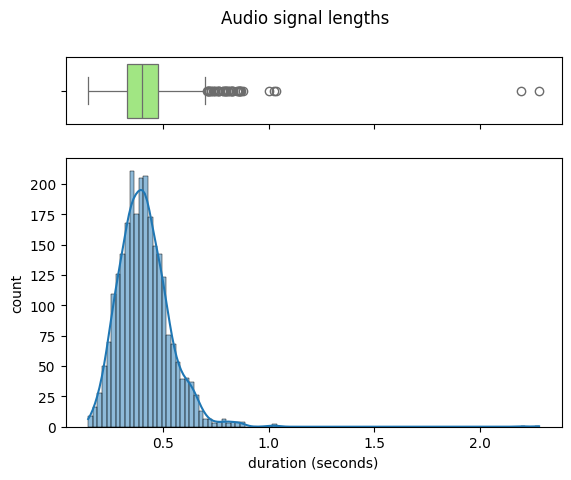

In [58]:
a = show_length_distribution(X)

In [ ]:
# show longest signal

# show shortest signal

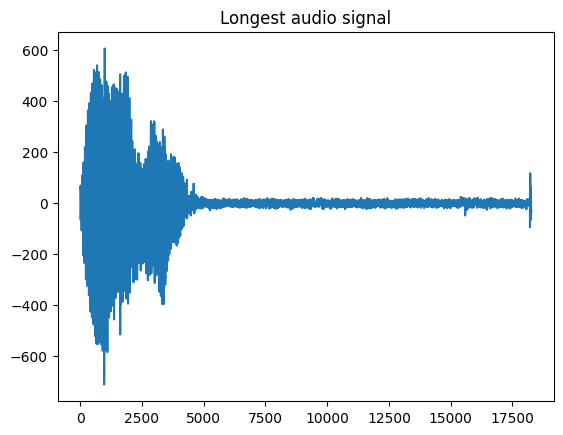

In [59]:
rate = 8000
Longest_audio = np.argmax([len(x) for x in X])
plt.plot(X[Longest_audio])
plt.title("Longest audio signal");


ipd.Audio(X[Longest_audio], rate=rate)

# https://www.kaggle.com/code/nagarmanthan/audio-processing-eda/notebook

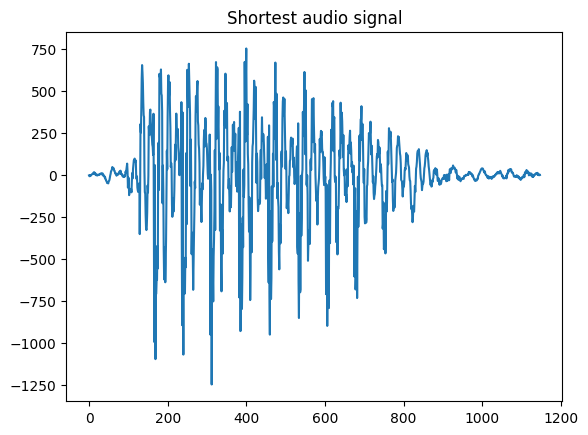

In [ ]:
Shortest_audio = np.argmin([len(x) for x in X])
plt.plot(X[Shortest_audio])
plt.title("Shortest audio signal");

ipd.Audio(X[Shortest_audio], rate=rate)

In [ ]:
X[Longest_audio][-5:]

array([  7,   6, -28, -39, -30])

In [ ]:
# by default anything below 10 db is considered as silence
def remove_silence(sample, sr= 8000, top_db = 10):
    """This function removes trailing and leading silence periods of audio signals.
    """
    y = np.array(sample, dtype = np.float64)
    # Trim the beginning and ending silence
    yt, _ = trim(y, top_db= top_db)
    return yt

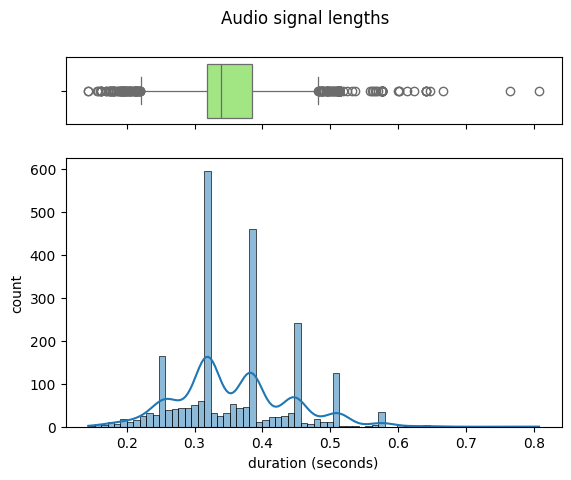

In [ ]:
X_tr = [remove_silence(x) for x in X]

show_length_distribution(X_tr);

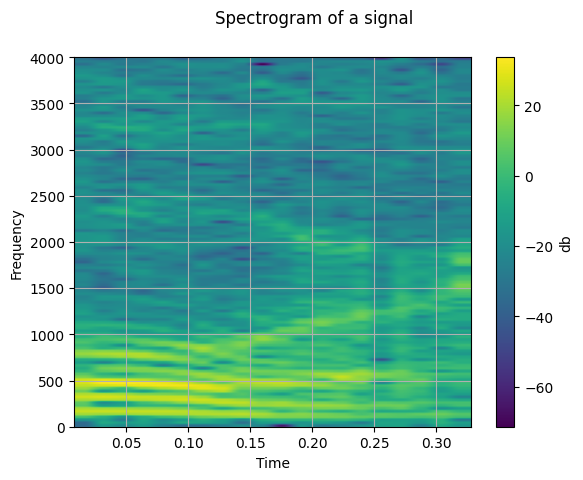

In [157]:
# Plotting the Frequency Spectrum of the signal
# Plot the spectrogram of power on log scale

# fig, ax = plt.subplots(figsize = (8,6))

powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(X[np.random.randint(100)], Fs=rate, scale = "dB")
cbar = plt.gcf().colorbar(imageAxis)
cbar.set_label('db')
plt.grid()
plt.suptitle("Spectrogram of a signal")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()


### Question 2 (Total 25 marks)

a) In the VQ-VAE, the variational posterior output by the encoder is deterministic:

$$q_\phi(z = e_k \mid x) = \left\{
\begin{array}{l}
~1 \quad\textrm{for}\quad k=\underset{j}{\arg\min} ||E(x) - e_j||\\
~0 \quad\textrm{otherwise}
\end{array}
\right.
$$

where in the above, $\phi$ represents the parameters of the encoder. Show that by choosing a simple uniform distribution over the codebook vectors $e_i$ as the prior distribution $p(z)$, the KL-divergence term of the ELBO objective is equal to a constant.

**(5 marks)**

We have


\begin{align}
D_{KL}\left( q_\phi({z}\mid{x}) || p_\theta({z}) \right) = \sum_{k}^{K} q_\phi(z = e_k\mid x)\log\left(\frac{q_\phi({z = e_k}\mid{x})}{p_\theta({z})}\right)
\end{align}

And we know that  $p_{\theta(z)}=\frac{1}{K}$ Therefore we have:

\begin{align}
D_{KL}\left( q_\phi({z}\mid{x}) || p_\theta({z}) \right) &= \log(K) \ \sum_{k}^{K} q_\phi(z = e_k\mid{x}) +  \sum_{k}^{K} q_\phi(z = e_k\mid x)\log\left(q_\phi(z = e_k \mid x)\right) \\
& = \log(K) + 0 = \log(K) \text{ since } f(u) = u \log(u) \text{ is zero at } x=0
\end{align}

$

b) The VQ-VAE as described above has an implementation that is available on the Keras website [here](https://keras.io/examples/generative/vq_vae/). In particular, the implementation of the vector quantisation and addition of the codebook and commitment loss is done with the `VectorQuantizer` layer.

You should write your own custom Layer class that is based on the `VectorQuantizer` layer, but with the following amendments:

1) The codebook loss should be removed, and instead the layer should use exponential moving average updates for the codebook during training, as follows:
$$
N_i^{(t)} := N_i^{(t-1)} * \gamma + n_i^{(t)}(1 - \gamma),\quad m_i^{(t)} := m_i^{(t-1)} * \gamma + \sum_j^{n_i^{(t)}} E(x)_{i,j}^{(t)}(1-\gamma),\quad e_i^{(t)} :=\frac{m_i^{(t)}}{N_i^{(t)}},\qquad i=1,\ldots,K
$$
where $n_i^{(t)}$ is the number of vectors in $E(x)$ in the minibatch that are quantized to codebook vector $e_i$ (cluster size), and $0 < \gamma < 1$ is a decay parameter, normally set to $\gamma=0.99$ as default. The moving averages are typically initialised as $m_i^{(0)} = e_i^{(0)}$ and $N_i^{(0)} = 0$. Note that the above update is independent of the gradient-based optimizer used to update the parameters of the encoder and decoder networks.

2) In place of the (single) codebook vector quantisation, your custom Layer class should use _residual vector quantisation_ (RVQ). This is a multi-stage vector quantiser, which involves $N_q$ layers of vector quantisation as follows. Define a sequence of codebooks $\mathbf{e}^{(j)}\in\mathbb{R}^{K\times D}$, $j=1,\ldots,N_q$. Codebook $\mathbf{e}^{(j)}$ consists of $K$ latent embedding vectors $e_i^{(j)}$, each of dimension $D$ as before.

The encoder output $E(x)$ is first quantised using the first codebook:

$$VQ^{(1)}(E(x)) = e_k^{(1)},\quad\textrm{where }k = \underset{j}{\arg\min}||E(x) - e_j^{(1)}||_2,$$
    
The residual $\hat{e}^{(1)} := E(x) - VQ^{(1)}(E(x))$ is then quantised using the second codebook to give $VQ^{(2)}(\hat{e}^{(1)})$, and so on. The RVQ layer then sends the sum of the quantised vectors on to the decoder. The algorithm is summarised in the following pseudocode.

<img src="figures/rvq_pseudocode.png" alt="RVQ pseudocode" style="width: 450px;"/>

**(15 marks)**

In [ ]:

## exploded version 1
w_init = tf.random_uniform_initializer()
w = tf.Variable(
            initial_value=w_init(
                shape=(5, 3), dtype="float32"
            ),
            trainable=False,
            name="embeddings_vqvae",
        )


epsilon = 1e-5
batch_dim = 3
training = True

x = tf.random.gamma((3, 6), alpha=2., beta=2.)
num_embeddings = 4
embedding_dim  = 2
beta = 0.25
decay = 0.99
tf.random.set_seed(1)
w_init = tf.random_uniform_initializer()
embeddings = tf.Variable(
            initial_value = w_init(
                shape=(embedding_dim, num_embeddings), dtype="float32"
            ),
            trainable=False, # since we will use the moving average
            name="embeddings_vqvae",
        )

ma_denominator = tf.Variable([0.0]*num_embeddings,trainable=False, name='ema_cluster_size')
ma_numerator   = tf.Variable(embeddings, trainable=False, name='ema_sum_weights')
input_shape    = tf.shape(x)
flattened      = tf.reshape(x, [-1, embedding_dim])
similarity     = tf.matmul(flattened, embeddings)
distances       = (tf.reduce_sum(flattened ** 2, axis=1, keepdims=True)
                + tf.reduce_sum(embeddings ** 2, axis=0)
                - 2 * similarity)
# Derive the indices for minimum distances.
encoding_indices = tf.argmin(distances, axis=1)
encoding_indices
encodings = tf.one_hot(encoding_indices, num_embeddings)
quantized = tf.matmul(encodings, embeddings, transpose_b=True)
#quantized = tf.reshape(quantized, input_shape)
#commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
if training:
    nit = tf.cast(tf.reduce_sum(encodings, 0), tf.float32)
    ma_denominator =  decay*ma_denominator + (1-decay)*nit
    quantized_zij = tf.matmul(flattened, encodings, transpose_a = True)
    ma_numerator = decay*ma_numerator+(1-decay)*quantized_zij
    embeddings = ma_numerator / ma_denominator

## finish

# Straight-through estimator.
#quantized = x + tf.stop_gradient(quantized - x)


In [ ]:
ma_numerator

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[-0.03315205,  0.09335099,  0.04973616, -0.00647993],
       [-0.02059804,  0.03257543,  0.13546015, -0.00642515]],
      dtype=float32)>

In [ ]:
## with regular loop

nq = 10
epsilon = 1e-5
batch_dim = 3
training = True

tf.random.set_seed(1)
x = tf.random.gamma((16, 12), alpha=2., beta=2.)
num_embeddings = 4
embedding_dim  = 12
beta = 0.25
decay = 0.99


w_init = tf.random_uniform_initializer()
embeddings = [tf.Variable(
            initial_value = w_init(
                shape=(embedding_dim, num_embeddings), dtype="float32"
            ),
            trainable=False, # since we will use the moving average
            name="embeddings_vqvae_"+str(i),
            ) for i in range(nq)]

ma_denominator = [tf.Variable(tf.zeros((num_embeddings)),trainable=False, name='ema_cluster_size_'+str(i)) for i in range(nq)]
ma_numerator   = [tf.Variable(embeddings[0], trainable=False, name='ema_sum_weights_'+str(i)) for i in range(nq)]
input_shape    = tf.shape(x)
flattened      = tf.reshape(x, [-1, embedding_dim])
i = 0
residuals      = tf.Variable(flattened)
quantized      = tf.Variable(tf.zeros((flattened.shape)))
while i < nq:
    print(quantized)
    similarity     = tf.matmul(residuals, embeddings[i])
    distances      = (tf.reduce_sum(residuals ** 2, axis=1, keepdims=True)
                    + tf.reduce_sum(embeddings[i] ** 2, axis=0)
                    - 2 * similarity)
    # Derive the indices for minimum distances.
    encoding_indices = tf.argmin(distances, axis=1)
    encodings = tf.one_hot(encoding_indices, num_embeddings)
    quantized_temp = tf.matmul(encodings, embeddings[i], transpose_b=True)
    quantized = quantized.assign_add(quantized_temp)
    residuals = residuals.assign_sub(quantized_temp)
    #quantized = tf.reshape(quantized, input_shape)
    #commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
    if training:
        nit = tf.cast(tf.reduce_sum(encodings, 0), tf.float32)
        ma_denominator[i] =  decay*ma_denominator[i] + (1-decay)*nit
        quantized_zij = tf.matmul(residuals, encodings, transpose_a = True)
        ma_numerator[i] = decay*ma_numerator[i]+(1-decay)*quantized_zij
        embeddings[i].assign((ma_numerator[i]+epsilon) / (ma_denominator[i]+epsilon))
    i += 1
    ## finish

    # Straight-through estimator.
    #quantized = x + tf.stop_gradient(quantized - x)
quantized

<tf.Variable 'Variable:0' shape=(16, 12) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>
<tf.Vari

<tf.Variable 'UnreadVariable' shape=(16, 12) dtype=float32, numpy=
array([[ 8.58935714e-02, -7.29213357e-02,  8.68878812e-02,
         1.23226643e-01,  6.06238768e-02,  3.26874033e-02,
         1.39984824e-02, -8.67173970e-02,  9.34850350e-02,
         9.73915681e-02,  2.26998672e-01,  2.68556207e-01],
       [-8.81047919e-04,  6.11319803e-02,  2.18846858e-01,
        -4.79858369e-04, -3.86548825e-02,  4.88287024e-02,
         4.61088829e-02, -8.74184221e-02,  1.70666903e-01,
         1.24820769e-01,  6.32721186e-02,  2.92527914e-01],
       [ 1.18931442e-01,  9.51837376e-02,  3.22499871e-02,
         3.62868980e-02,  5.21644615e-02,  1.49523631e-01,
        -2.80906931e-02, -4.63857390e-02,  1.86726391e-01,
         2.35511176e-02,  1.28978252e-01,  2.13922352e-01],
       [ 1.52827486e-01, -7.58904219e-03,  5.68693727e-02,
        -1.96608938e-02,  1.62072361e-01,  1.65993333e-01,
        -7.13941902e-02, -1.10859707e-01,  1.19781516e-01,
        -2.64038816e-02,  2.66324818e-01,  1.

In [ ]:



## with tf.whileloop

nq = 3
epsilon = 1e-5
batch_dim = 3
training = True

tf.random.set_seed(1)
x = tf.random.gamma((16, 12), alpha=2., beta=2.)
num_embeddings = 4
embedding_dim  = 12
beta = 0.25
decay = 0.99


w_init = tf.random_uniform_initializer()
embeddings = [tf.Variable(
            initial_value = w_init(
                shape=(embedding_dim, num_embeddings), dtype="float32"
            ),
            trainable=False, # since we will use the moving average
            name="embeddings_vqvae_"+str(i),
            ) for i in range(nq)]

ma_denominator = [tf.Variable(tf.zeros((num_embeddings)),trainable=False, name='ema_cluster_size_'+str(i)) for i in range(nq)]
ma_numerator   = [tf.Variable(embeddings[0], trainable=False, name='ema_sum_weights_'+str(i)) for i in range(nq)]
input_shape    = tf.shape(x)
flattened      = tf.reshape(x, [-1, embedding_dim])
i = 0
residuals      = tf.Variable(flattened)
quantized      = tf.Variable(tf.zeros((flattened.shape)))
c = lambda i, _a, _b, _c, _d, _e : tf.less(i, n)

def one_iteration(i, quantized, residuals):
    similarity     = tf.matmul(residuals, tf.gather(embeddings,i))
    distances      = (tf.reduce_sum(residuals ** 2, axis=1, keepdims=True)
                    + tf.reduce_sum(tf.gather(embeddings,i) ** 2, axis=0)
                    - 2 * similarity)

    # Derive the indices for minimum distances.
    encoding_indices = tf.argmin(distances, axis=1)
    encodings = tf.one_hot(encoding_indices, num_embeddings)
    quantized_temp = tf.matmul(encodings, tf.gather(embeddings,i), transpose_b=True)
    #print(quantized_temp)
    quantized = quantized + quantized_temp
    residuals = residuals - quantized_temp
    #quantized = tf.reshape(quantized, input_shape)
    #commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)

    if training:
        nit = tf.cast(tf.reduce_sum(encodings, 0), tf.float32)
        ma_denominator[i] =  decay*tf.gather(ma_denominator,i) + (1-decay)*nit
        quantized_zij = tf.matmul(residuals, encodings, transpose_a = True)
        ma_numerator[i] = decay*tf.gather(ma_numerator,i)+(1-decay)*quantized_zij
        embeddings[i].assign((tf.gather(ma_numerator,i)+epsilon) / (tf.gather(ma_denominator,i)+epsilon))
    #print("passed this")
    #print(i)
    #print(quantized)
    #print(residuals)
    return (i+1, quantized, residuals)

c = lambda i, _a, _b: tf.less(i, nq)
i = 0
i, quantized, residuals = tf.while_loop(c, one_iteration, [i, tf.constant(quantized), tf.constant(residuals)])
    ## finish

    # Straight-through estimator.
    #quantized = x + tf.stop_gradient(quantized - x)
quantized

<tf.Tensor: shape=(16, 12), dtype=float32, numpy=
array([[ 0.08254009, -0.00451889,  0.00330713,  0.00890845,  0.01043343,
         0.12784633, -0.05090779, -0.03823388,  0.11316487, -0.01918602,
         0.06191299,  0.06677254],
       [ 0.05605431,  0.05541421,  0.04107412,  0.01432769, -0.04701265,
         0.07394546, -0.06348579, -0.03535115,  0.13054462,  0.00132396,
        -0.0216518 ,  0.12625828],
       [ 0.08254009, -0.00451889,  0.00330713,  0.00890845,  0.01043343,
         0.12784633, -0.05090779, -0.03823388,  0.11316487, -0.01918602,
         0.06191299,  0.06677254],
       [ 0.08254009, -0.00451889,  0.00330713,  0.00890845,  0.01043343,
         0.12784633, -0.05090779, -0.03823388,  0.11316487, -0.01918602,
         0.06191299,  0.06677254],
       [ 0.00115825,  0.02989307,  0.06146821,  0.05838475, -0.01574077,
         0.07043964, -0.04513717, -0.0185791 ,  0.12670073, -0.05052299,
        -0.0388333 ,  0.11016902],
       [ 0.02764404, -0.03004003,  0.02370123

In [ ]:
embeddings

[<tf.Variable 'embeddings_vqvae_0:0' shape=(12, 4) dtype=float32, numpy=
 array([[ 5.8998328e-01,  6.1563867e-01, -9.0452240e+02,  1.6728690e+00],
        [ 1.9394251e+00,  4.0285978e-01, -6.3193695e+02,  9.2647225e-01],
        [ 1.1174419e+00,  2.0117507e+00, -3.0878276e+03,  7.2320718e-01],
        [ 1.5530285e+00,  1.1121467e+00, -2.1780425e+03,  3.1442699e-01],
        [ 1.3226470e+00,  1.8799833e+00,  3.2040396e+02,  6.6325557e-01],
        [-4.6337649e-01,  1.8703089e+00, -3.8626116e+03,  1.6045406e+00],
        [ 2.2445836e+00,  6.2751365e-01,  2.9184526e+03,  6.5612292e-01],
        [ 2.1404099e+00,  2.1459451e+00,  3.5741216e+03,  9.0873712e-01],
        [-4.2212987e-01,  1.9867724e+00,  3.0161694e+03,  1.8111413e+00],
        [ 2.6954715e+00, -5.3119707e-01, -7.3026038e+02,  1.1233457e+00],
        [ 2.5236157e-01,  2.7459282e-01, -4.4114288e+01,  1.4267725e+00],
        [-3.6796984e-01,  9.6490282e-01, -2.8370234e+03,  1.3372242e+00]],
       dtype=float32)>,
 <tf.Variable 

In [ ]:
kk = 32
@tf.function
def sumSquare2(n):
  i, result, bob = tf.constant(0), tf.constant(0), tf.constant(5)
  c = lambda i, _, _a : tf.less(i, n)
  b = lambda i, result, bob: (i + 1, result +kk+ i * i, bob)
  return tf.while_loop(c, b, [i, result, bob])[1]
sumSquare2(10).numpy()


605

In [158]:
# we are not learning the codebook vectors anymore.

from tensorflow.keras import layers
from tensorflow import keras

class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

class RVQVectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, nq = 4, decay = 0.99, epsilon = 1e-7, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim  = embedding_dim
        self.num_embeddings = num_embeddings
        self.nq = nq
        self.decay = decay
        self.epsilon = epsilon

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = [tf.Variable(
            initial_value = w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=False, # since we will use the moving average
            name="embeddings_vqvae_"+str(i),
            ) for i in range(self.nq)]

        self.ma_denominator = [tf.Variable(tf.zeros((self.num_embeddings)),trainable=False,
                                           name='ema_cluster_size_'+str(i)) for i in range(self.nq)]
        self.ma_numerator   = [tf.Variable(self.embeddings[i], trainable=False,
                                           name='ema_sum_weights_'+str(i)) for i in range(self.nq)]

    def call(self, x, training = None):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        def one_stage_quantization(i, quantized, residuals):
            #print(tf_look_up[i])
            #print(quantized)
            #print(residuals)
            similarity     = tf.matmul(residuals, tf.gather(self.embeddings,i))
            distances      = (tf.reduce_sum(residuals ** 2, axis=1, keepdims=True)
                            + tf.reduce_sum(tf.gather(self.embeddings,i) ** 2, axis=0)
                            - 2 * similarity)

            # Derive the indices for minimum distances.
            encoding_indices = tf.argmin(distances, axis=1)
            encodings = tf.one_hot(encoding_indices, self.num_embeddings)
            quantized_temp = tf.matmul(encodings, tf.gather(self.embeddings,i), transpose_b=True)
            quantized = quantized + quantized_temp
            residuals = residuals - quantized_temp
            #quantized = tf.reshape(quantized, input_shape)
            #commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)

            if training:
                nit = tf.cast(tf.reduce_sum(encodings, 0), tf.float32)
                self.ma_denominator[i] =  self.decay*tf.gather(self.ma_denominator,i) + (1-self.decay)*nit
                quantized_zij = tf.matmul(residuals, encodings, transpose_a = True)
                self.ma_numerator[i] = self.decay*tf.gather(self.ma_numerator,i)+(1-self.decay)*quantized_zij
                self.embeddings[i].assign((tf.gather(self.ma_numerator,i)+self.epsilon) / (tf.gather(self.ma_denominator,i)+self.epsilon))
            return (i+1, quantized, residuals)

        condition         = lambda i, _a, _b: tf.less(i, self.nq)
        i                 = 0
        residuals_init    = flattened
        quantized_init    = tf.zeros(tf.shape(flattened))
        i, quantized, residuals = tf.while_loop(condition, one_stage_quantization,
                                                [i, quantized_init,
                                                 residuals_init])
        #quantized = tf.Variable(quantized_tensor)
        #residuals = tf.Variable(residuals_tensor)
        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)
        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        #codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss) #+ codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized




c) Test your custom vector quantisation layer above by training a simple model on MNIST and displaying a few reconstructions of the model.

**(5 marks)**

In [159]:
def get_encoder(latent_dim=16):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")


def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = RVQVectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    #vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(28, 28, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")


get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (RVQVecto  (None, 7, 7, 16)          8448      
 rQuantizer)                                                     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 56337 (220.07 KB)
Trainable params: 47889 (187.07 KB)
Non-trainable params: 8448 (33.00 KB)
_________________________________________________________________


In [160]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128,
                 **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) /\
                self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [161]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

11490434/11490434 [==============================] - 0s 0us/step


In [163]:
data_variance

0.09493041879725218

In [162]:
def reconstruction_loss(y_true, y_pred):
    return -y_pred.log_prob(y_true)

vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam(),
                      loss=reconstruction_loss, metrics=['accuracy'])
history = vqvae_trainer.fit(x_train_scaled,
                            epochs=30,
                            batch_size=128)

Epoch 1/30
469/469 [==============================] - 10s 10ms/step - loss: 1.0515 - reconstruction_loss: 0.2403 - vqvae_loss: 0.4788
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - loss: 1.0139 - reconstruction_loss: 0.0454 - vqvae_loss: 0.9647
Epoch 3/30
469/469 [==============================] - 4s 10ms/step - loss: 0.9195 - reconstruction_loss: 0.0364 - vqvae_loss: 0.8816
Epoch 4/30
469/469 [==============================] - 4s 9ms/step - loss: 0.8770 - reconstruction_loss: 0.0322 - vqvae_loss: 0.8441
Epoch 5/30
469/469 [==============================] - 4s 9ms/step - loss: 0.8404 - reconstruction_loss: 0.0296 - vqvae_loss: 0.8103
Epoch 6/30
469/469 [==============================] - 5s 10ms/step - loss: 1.0629 - reconstruction_loss: 0.0302 - vqvae_loss: 1.0279
Epoch 7/30
469/469 [==============================] - 4s 8ms/step - loss: 0.8224 - reconstruction_loss: 0.0271 - vqvae_loss: 0.7952
Epoch 8/30
469/469 [==============================] - 4s 9ms/step - loss

1/1 [==============================] - 0s 19ms/step


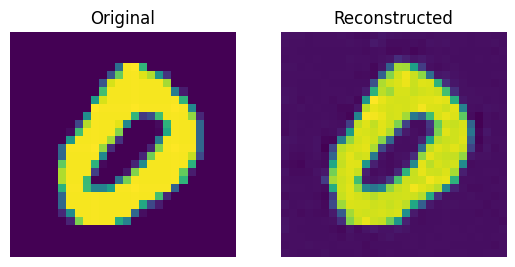

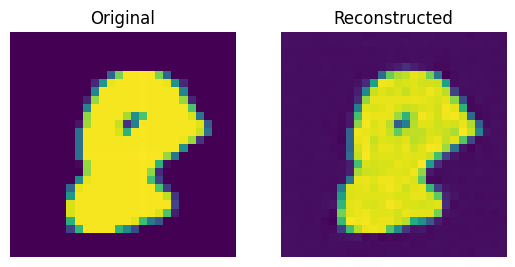

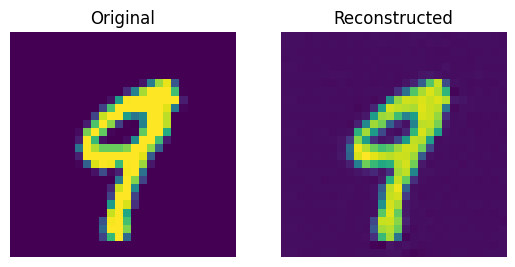

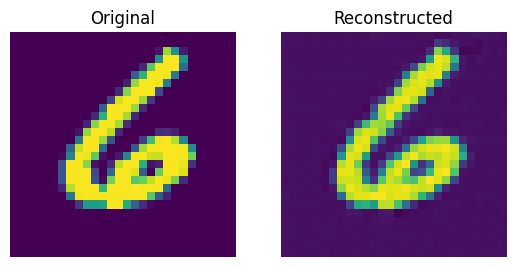

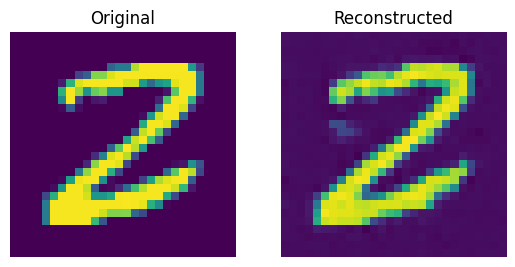

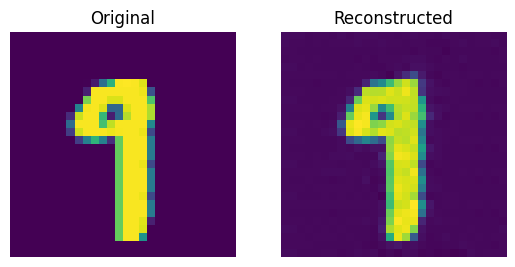

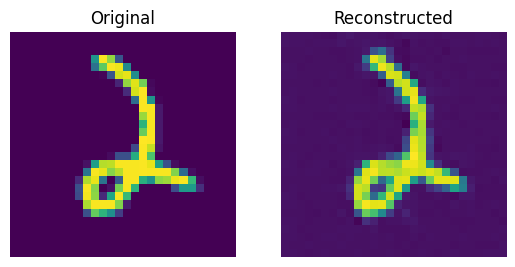

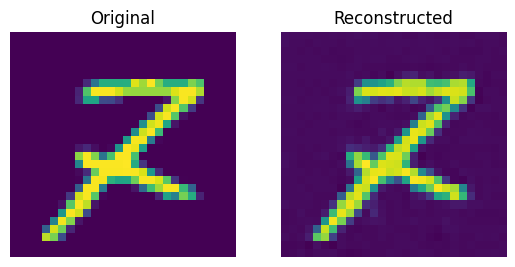

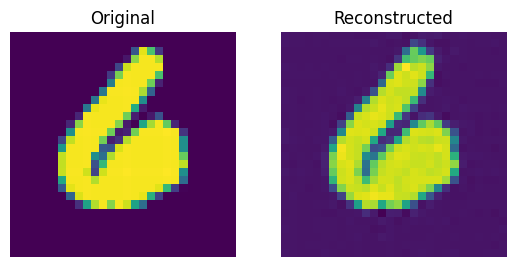

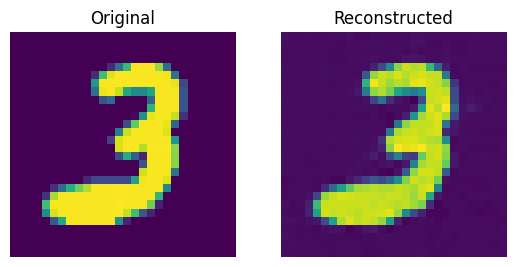

In [ ]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

### Question 3 (Total 40 marks)

a) Design, implement and train a VQ-VAE for the spoken digit dataset. You are free to choose any architecture for the encoder and decoder networks, but your model should use the custom RVQ layer from question 2, with $N_q\ge2$ codebooks. (If you have been unable to implement this custom layer, then you should use the `VectorQuantizer` layer from the [Keras website](https://keras.io/examples/generative/vq_vae/)). You can also make additions or modifications to the training algorithm if you wish.

Your trained model should output a sequence of codebook vectors using the encoder and RVQ layer, which are then decoded by the decoder network to reconstruct the original input.

You should record any experiments you carry out along with the training logs, to be reported in question 4. Your code in this question does not need to be presented so that it runs all experiments, it can be set out to run the best experiment only.

Display some examples (playable using the `Audio` class from the `IPython.display` module as in question 1) from the dataset along with their reconstructions to demonstrate the trained model.

**(25 marks)**

We will need to create a few custom layers to handle the masking of padding values in the inputs.

In [ ]:
#RAVE: A variational autoencoder for fast and high-quality neural audio synthesis
#https://www.kaggle.com/code/basu369victor/generate-music-with-variational-autoencoder

In [ ]:
#https://yuehan-z.medium.com/introduction-to-vaes-in-ai-music-generation-d8e0cfc2245b

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_sound (InputLayer)    [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 64)          4194240   
                                                                 
Total params: 4194240 (16.00 MB)
Trainable params: 4194240 (16.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


TensorShape([64, 7038])

b) The VQ-VAE quantisation layer emits a sequence of discrete codes for a given audio input. During training, the prior distribution over these codes is kept uniform. In order to use the model to generate audio, it is necessary to train a second model to predict likely sequences of codebook vectors.

This second model is usually referred to in the literature as a 'prior' model (note that this is not really a prior, as it is trained on the data). We will adopt this same terminology here.

You should design, implement and train a prior model to generate sequences of codebook vectors, using the output of the trained VQ-VAE encoder and quantisation stage, using the same training data that was used to train the VQ-VAE. You are again free to choose any architecture for the prior model.

Your trained model should generate a sequence that can be decoded by the VQ-VAE to output audio.

You should record any experiments you carry out along with the training logs, to be reported in question 4. Your code in this question does not need to be presented so that it runs all experiments, it can be set out to run the best set of hyperparameters, according to your validation results. You should aim to try at least two sets of hyperparameters.

Display some examples (playable using the Audio class from the IPython.display module as in question 1) generated using your prior and VQ-VAE model.

**(15 marks)**

### Question 4 (Total 15 marks)

Provide a separate PDF report with an account of the models and experiment design you have made in question 3. Your report should include details of the choices you have made throughout the development of the models, including the data processing, architecture design, hyperparameter settings/experiments and training algorithm. Where appropriate, you can also provide your intuition behind these choices.

Your report should also include the results from your experiments, highlighting the best choice of hyperparameters that you found. If you encountered difficulties to successfully train the model(s) you should report these, and if possible suggest what you think might be potential reasons for these difficulties. Are there additional experiments or modifications to the model and/or training algorithm that you would have liked to make given more time?

Marks will be awarded for presentation and clarity. Your report should be no more than 2-3 pages.

**(15 marks)**